In [48]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

#### Below is the PYTHON FILE but I print it here for you 

In [72]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings


def ising(N):
    np.random.seed(123)  

    terms = []

    # Generate random coefficients for the transverse field term (X)
    a_coefficients = np.random.random(N)
    for i in range(N):
        term = Term(coefficient=a_coefficients[i], pauli_op="X", qbits=[i])
        terms.append(term)

    # Generate random coefficients for the interaction term (ZZ)
    J_coefficients = np.random.random((N, N))
    for i in range(N):
        for j in range(i):
            if i != j:  # avoid duplicate terms
                term = Term(coefficient=J_coefficients[i, j], pauli_op="ZZ", qbits=[i, j])
                terms.append(term)
    ising = Observable(N, pauli_terms=terms, constant_coeff=0.0)
    return ising


def Molecule_Generator(model):
    if model == "H2":
        r = 0.75
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    elif model == "H4":
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
  
    return r, geometry, charge, spin, basis




def circuit_ansatz(nqbits,k, depth, theta_list):
    
    """Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :circuit`
    """
    prog = Program()
    reg = prog.qalloc(nqbits)

    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This applied state is ", state_pad)

    prog.apply(RY(theta_list[-2]), reg[0])
    prog.apply(RZ(theta_list[-1]), reg[0])

    for d in range(depth):
        
        for i in range(nqbits):
            prog.apply(RY(theta_list[2*i+2*nqbits*d]), reg[i])
            prog.apply(RZ(theta_list[2*i+1+2*nqbits*d]), reg[i])
        
        for i in range(nqbits//2):
            prog.apply(CNOT, reg[2*i+1], reg[2*i])
        
        for i in range(nqbits//2-1):
            prog.apply(CNOT, reg[2*i+2], reg[2*i+1])

    for i in range(nqbits):
        prog.apply(RY(theta_list[2*i+2*nqbits*depth]), reg[i])
        prog.apply(RZ(theta_list[2*i+1+2*nqbits*depth]), reg[i])

    return prog.to_circ()



def get_optimization_func(circuits, H_sp, qpu, nqbits, methods, energy_list):
    def my_func(x):
        energies = []
        for circ in circuits:
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=H_sp))
            energy = result.value
            energies.append(energy)
        
        for i, method in enumerate(methods):
            energy_list[method].append(energies[i])

        energy_total = sum((i + 1) * energy for i, energy in enumerate(energies))
        return energy_total

    def callback(x):
        my_func(x)

    return my_func, callback

#### Now is the notebook version that you can practically call it from the python file 

In [50]:
#model = ising(4) 
#print("Transverse Ising Model:", model)

In [51]:
name = Molecule_Generator("H2")

In [52]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_elec,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_elec)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  2
Number of qubits before active space selection =  4
Orbital energies =  [-0.57443656  0.66091005]
Nuclear repulsion =  0.70556961456


In [53]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()

model = transform_to_jw_basis(H)
print(model)

(-0.10973055606700713+0j) * I^4 +
(0.16821198673715726+0j) * (ZZ|[0, 1]) +
(0.12005143072546025+0j) * (ZZ|[0, 2]) +
(0.16549431486978644+0j) * (ZZ|[1, 2]) +
(0.16549431486978644+0j) * (ZZ|[0, 3]) +
(0.16988452027940376+0j) * (Z|[0]) +
(0.12005143072546025+0j) * (ZZ|[1, 3]) +
(0.16988452027940376+0j) * (Z|[1]) +
(0.04544288414432621+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.04544288414432621+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.04544288414432621+0j) * (YYXX|[0, 1, 2, 3]) +
(0.04544288414432621+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17395378776494128+0j) * (ZZ|[2, 3]) +
(-0.21886306781219628+0j) * (Z|[2]) +
(-0.21886306781219628+0j) * (Z|[3])


In [54]:
print("This model has the number of qubit:", model.nbqbits)
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=13)
print(eigval)

This model has the number of qubit: 4
[-1.13711707  0.9014838   0.70556961  0.45980452  0.33373738 -0.4552414
  0.33373738 -0.4552414  -0.54171489 -0.5427821  -0.5427821  -0.54171489
 -0.5427821 ]


In [55]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [56]:
import numpy as np

nqbits = 4
depth = 4

# Introducing the list of excitations
k_lst = [0, 4, 13, 6]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]

# Define a function to create and display a circuit
def create_circuit(k):
    return circuit_ansatz(4, k, 4, theta)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()


This applied state is  0000
This applied state is  0100
This applied state is  1101
This applied state is  0110


In [57]:
import scipy
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
nqubits = 4
circuits = circuits_store
H_sp = model 
methods = ["BFGS"]
energy_lists = {method: [] for method in methods}





In [58]:
def get_optimization_func(circuits, H_sp, qpu, nqbits, methods, energy_list):
    def my_func(x):
        energies = []
        for circ in circuits:
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=H_sp))
            energy = result.value
            energies.append(energy)
        
        for i, method in enumerate(methods):
            energy_list[method].append(energies[i])

        energy_total = sum((i + 1) * energy for i, energy in enumerate(energies))
        return energy_total

    def callback(x):
        my_func(x)

    return my_func, callback


my_func, callback = get_optimization_func(circuits, H_sp, qpu, nqubits, methods, energy_lists)


options = {"disp": True, "maxiter": 500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(my_func, x0=init_theta_list, method="BFGS", callback=callback)

In [59]:
print(Optimizer)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -7.72023118065182
        x: [ 8.167e-01  1.571e+00 ...  8.437e-07 -3.154e-07]
      nit: 70
      jac: [ 2.980e-07 -2.384e-07 ...  5.364e-07 -5.960e-08]
 hess_inv: [[ 9.064e-01 -3.668e-02 ...  3.375e-01 -4.768e-03]
            [-3.668e-02  2.142e+00 ... -1.689e-02 -1.201e-03]
            ...
            [ 3.375e-01 -1.689e-02 ...  6.632e-01  2.947e-03]
            [-4.768e-03 -1.201e-03 ...  2.947e-03  6.576e-01]]
     nfev: 3483
     njev: 81


In [66]:
print(Optimizer.x)

[ 8.16702546e-01  1.57079786e+00  1.45673350e-04 -2.42546549e-01
 -1.54533520e-06  2.52429170e-06 -2.13430434e-02 -6.30825715e-07
  9.41166352e-08 -1.57079162e+00  1.40637360e-06 -5.83529416e-03
 -1.57080455e+00 -1.93832223e-06 -4.44681193e-07 -2.15793656e-02
 -8.83229613e-07  2.04529670e-07  1.07109470e+00  1.50325760e-04
 -1.57079545e+00  2.96732380e-07  4.24819200e-06 -2.90396605e-07
 -3.94133058e-02  1.57079751e+00  1.44294060e-02  2.42554436e-01
  9.49240441e-02  1.57079328e+00  2.21984006e-02 -1.79187235e-06
  1.55401890e-02  2.18316418e-02  7.54113313e-01  8.52256339e-03
 -4.99702573e-01  8.24152065e-05 -1.15371456e-07  1.15958588e-03
  8.43739603e-07 -3.15415129e-07]


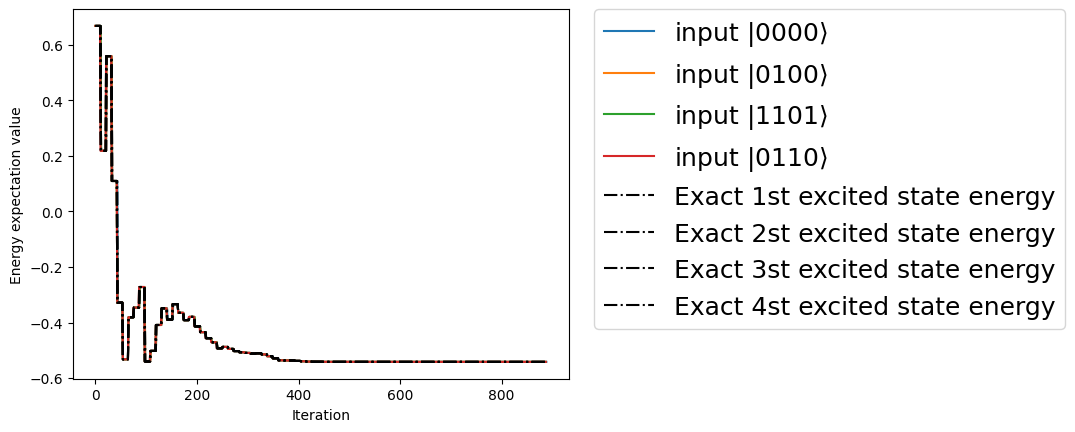

In [69]:
import matplotlib.pyplot as plt

# Assuming you have a single energy list for all cases


# Plot individual circuits
for i, k in enumerate(k_lst):
    plt.plot(energy_lists["BFGS"][i::len(k_lst)], label=r"input $|{" + bin(k)[2:].zfill(nqbits) + r"}\rangle$")

# Plot exact ground and excited state energies
for i, k in enumerate(k_lst):
    plt.plot(range(len(energy_lists["BFGS"][i::len(k_lst)])), energy_lists["BFGS"][i::len(k_lst)], linestyle="-.", color="black", label=f"Exact {i + 1}st excited state energy")

plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()
